In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from dipy.core.gradients import gradient_table
from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.ndindex import ndindex
from dipy.core.geometry import cart2sphere

from dipy.reconst.dti import (design_matrix, lower_triangular,
                              fractional_anisotropy, mean_diffusivity,
                              decompose_tensor, from_lower_triangular) 

from dipy.reconst.dki import _positive_evals

from dipy.reconst.vec_val_sum import vec_val_vect

from beltrami import (fraction_init_s0, fraction_init_md, fraction_init_hybrid,
                      tensor_init)

from dipy.sims.voxel import (_check_directions, single_tensor, multi_tensor, 
                             multi_tensor_dki, all_tensor_evecs, add_noise)

In [2]:
## Parameters to change for different simulation conditions
sel_gtab = 2 # if sel_gtab=1, simulations are performed for b-values of 0, 1000, 300
# if sel_gtab=2, simulations are performed for bvalues of 0, 1000, 2000

tissue_nonGaussian = True
# if false simulations are performed ignoring nonGaussian diffusion effects of tissue
# if true simulations are performed with nonGaussian diffusion effects of tissue
# using the NODDI model.

In [3]:
from scipy.special import erfi
import scipy.optimize as opt
from dipy.data import get_sphere

sphere = get_sphere('repulsion724')
sphere = sphere.subdivide(2)
s3s = sphere.vertices  # sampled 3d space

def generate_eigvalues(trace):
    """
    generates random eigenvalues whose sum is equal to trace
    """

    weight_1 = np.random.uniform(0.001, 0.3)
    weight_2 = np.random.uniform(0.3, 0.6)

    L1 = trace * weight_1
    L2 = trace * weight_2
    L3 = trace - (L1 + L2)

    eigvals = np.sort(np.vstack((L1, L2, L3)), axis=0)

    return np.flip(eigvals, axis=0).T


def dual_tensor(gtab, mevals, S0t=50, S0w=100, angles=[(0, 0), (90, 0)],
                fractions=[50, 50], snr=None):
    """
    custom fucntion similar to Dipy's 'sims.voxel.multi_tensor(...)', that
    simulates a dual tensor (free water model), modified to assume that the
    non-weihghted signal S0 is differnet for each compartment (S0t and S0w)
    """

    if np.round(np.sum(fractions), 2) != 100.0:
        raise ValueError('Fractions should sum to 100')

    fractions = [f / 100. for f in fractions]

    sticks = _check_directions(angles)

    S_tissue = single_tensor(gtab, S0=S0t, evals=mevals[0],
                                            evecs=all_tensor_evecs(sticks[0]),
                                            snr=None)

    S_water = single_tensor(gtab, S0=S0w, evals=mevals[1],
                                           evecs=all_tensor_evecs(sticks[1]),
                                           snr=None)

    S = fractions[0] * S_tissue + fractions[1] * S_water

    return add_noise(S, snr, S_tissue), S_tissue, sticks


def tau_from_odi(odi):
    """
    Convert dispersion index odi to dispersion index tau

    Parameters
    ----------
    odi : ndarray ([X, Y, Z, ...])
        ndarray containing the orientation dispersion index (ODI).

    Returns
    -------
    tau : ndarray ([X, Y, Z, ...])
        ndarray containing tau dispersion index (tau).
    """
    k = 1/np.tan(np.pi/2*odi)
    tau = 1 / (np.sqrt(np.pi*k)*np.exp(-k)*erfi(np.sqrt(k)))-1/(2*k)
    
    return tau


def _tau_from_odi_error(odi, tau):
    """ Helper function that calculates the difference between
    a tau prediction from an ODI value and a measured tau

    Parameters
    ----------
    f : float
        Axonal volume fraction estimate.
    msk : float
        Measured mean signal kurtosis.
    Returns
    -------
    error : float
       Error computed by subtracting msk with fun(f), where fun is the function
       described in equation 17 of [1]_
    Notes
    -----
    This function corresponds to the differential of equations 17 of [1]_
    """
    return tau_from_odi(odi) - tau

def odi_from_tau(tau, mask=None):
    """
    Convert dispersion index tau to dispersion index odi

    Parameters
    ----------
    tau : ndarray ([X, Y, Z, ...])
        ndarray containing tau dispersion index (tau).
        
    Returns
    -------
    odi : ndarray ([X, Y, Z, ...])
        ndarray containing the orientation dispersion index (ODI).
    """
    odi = np.zeros(tau.shape)

    # Prepare mask
    if mask is None:
        mask = np.ones(tau.shape, dtype=bool)
    else:
        if mask.shape != tau.shape:
            raise ValueError("Mask is not the same shape as data.")
        mask = np.array(mask, dtype=bool, copy=False)
        
    # Define tau reference points inside its domain
    odimin = 0.999
    odimed = 0.300
    odimax = 0.001
    
    tauref = tau_from_odi(np.array([odimin, odimed, odimax]))
    taumin = tauref[0]
    taumed = tauref[1]
    taumax = tauref[2]
    
    a0  = (odimed - odimin) / (taumed - taumin)
    b0 = odimin - a0 * taumin
    
    a1  = (odimax - odimed) / (taumax - taumed)
    b1 = odimed - a1 * taumed

    # looping voxels
    index = ndindex(mask.shape)
    for v in index:
        # Skip if out of mask
        if not mask[v]:
            continue

        if tau[v] < taumin:
            odi[v] = odimin
        elif tau[v] > taumax:
            odi[v] = odimax
        else:
            if tau[v] < taumed:
                odi_ini = a0 * tau[v] + b0
            else:
                odi_ini = a1 * tau[v] + b1
                
            odi[v] = opt.fsolve(_tau_from_odi_error, odi_ini, args=(tau[v],))

    return odi



def noddi_forward(gtab, v, d, k, Dw, S0t=50, S0w=100, 
                  angles=[(0, 0), (90, 0)], fractions=[50, 50], snr=None):
    """
    custom fucntion similar to Dipy's 'sims.voxel.multi_tensor(...)', that
    simulates a noddi forward model, modified to assume that the
    non-weihghted signal S0 is differnet for each compartment (S0t and S0w)
    """

    if np.round(np.sum(fractions), 2) != 100.0:
        raise ValueError('Fractions should sum to 100')

    fractions = [f / 100. for f in fractions]

    sticks = _check_directions(angles)
    
    f0 = np.exp(k*np.dot(s3s, sticks[0])**2)
    f = f0/np.sum(f0) * 100
    
    mevals = np.zeros(s3s.shape)
    mevals[:, 0] = d

    S_intra, _ = multi_tensor(gtab, mevals, S0=S0t, angles=s3s,
                              fractions=f, snr=None)
    
    #_, Dint, _ = multi_tensor_dki(gtab, mevals, S0=S0t, angles=s3s,
    #                               fractions=f, snr=None)
    
    mevals[:, 1] = d * (1 - v)
    mevals[:, 2] = d * (1 - v)
    
    _, Deff, _ = multi_tensor_dki(gtab, mevals, S0=S0t, angles=s3s,
                                  fractions=f, snr=None)
    
    evals, evecs = decompose_tensor(from_lower_triangular(Deff))
    
    S_extra = single_tensor(gtab, S0=S0t, evals=evals, evecs=evecs, snr=None)
    
    S_tissue = v*S_intra + (1-v)*S_extra

    S_water = single_tensor(gtab, S0=S0w, evals=np.array([Dw, Dw, Dw]),
                            evecs=np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),
                            snr=None)

    S = fractions[0] * S_tissue + fractions[1] * S_water

    return add_noise(S, snr, S_tissue), S_tissue, sticks

In [4]:
# ------------------------------------------------------------------------------
# Defining simulation parameters
# ------------------------------------------------------------------------------

# Parameters that define the number of simulations
n_pts = 30     # number of gradient directions
nMDs = 19      # number of simulated MD values
nFrac = 13     # number of simulated F values
nDTdirs = 1  # number of diffusion tensor principal directions
SNR = 30       # noise level simulated for nReps instances

# Ground truth parameters of a single voxel signal
MDs = np.linspace(0.2, 1.1, num=nMDs)
FA = 0.7

AD = MDs * (1 + (2 * FA)/np.sqrt(3 - 2 * FA**2));
RD = (3*MDs - AD) / 2

FAs = FA + 0 * MDs

if tissue_nonGaussian:
    v = 0.7
    c = 3 / (2*(1-v)**2+1)
    d = c*MDs
    
    tau = 1/3 * (1 + 4/(c-1) * FAs / (np.sqrt(3 - 2*FAs**2)))
    ODI = odi_from_tau(tau)
    k_con = 1/np.tan(np.pi/2*ODI)

else:
    L1s = AD
    L2s = RD
    L3s = RD


Dw = 3

FWs = np.linspace(0.1, 0.7, num=nFrac)
Fs = 1 - FWs

print('----------------------------- Parameters -----------------------------')
# print('ground truth FWs are ' + str(FWs))
print('Ground truth FA is ' + str(FA))
# print('ground truth MDs are ' + str(MDs))

----------------------------- Parameters -----------------------------
Ground truth FA is 0.7


In [5]:
# ------------------------------------------------------------------------------
# Simulating S0 signal
# ------------------------------------------------------------------------------

# Parameters that define the unweighted signal at 3T (assuming no T1 relaxation)
# T2 relaxation (ms)
T2_tissue = 80  # Wansapura et al., 1999
T2_water = 500  # Piechnik et al., 2009

# Proton density (percentage units)
PD_tissue = 70  # Abbas et al., 2015
PD_water = 100  # proton density of free water is always 100

# Typical TE value
TE = 104

# Assuming no T1 relaxation, the non-weighted signal for a voxel that has only
# tisssue or only water:
k = 10
St = k * PD_tissue * np.exp(-TE / T2_tissue)
Sw = k * PD_water * np.exp(-TE / T2_water)
S0s = Fs * St + FWs * Sw
F_cor = Fs * Sw / ((1 - Fs) * St + Fs * Sw)

print('S0 signal for a voxel with only tissue is ' + str(St))
print('S0 signal for a voxel with only water is ' + str(Sw))
print(('S0 signal for voxel with ' + str(0.5*100) + ' % tissue: ' +
       str(St * 0.5 + Sw * 0.5) + '\n(TE = ' + str(np.round(TE)) + ' ms)'))
print('-----------------------------------------------------------------------')

S0 signal for a voxel with only tissue is 190.7722551238088
S0 signal for a voxel with only water is 812.207036711939
S0 signal for voxel with 50.0 % tissue: 501.48964591787393
(TE = 104 ms)
-----------------------------------------------------------------------


In [6]:
Sw/St

4.257469390320027

In [7]:
Fs

array([0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 , 0.45, 0.4 ,
       0.35, 0.3 ])

In [8]:
MDs

array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ])

In [9]:
# ------------------------------------------------------------------------------
# Simulating acquisition gradients
# ------------------------------------------------------------------------------

# Sample the spherical cordinates of 32 evenly distributed
# diffusion-weighted directions
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions = hsph_updated.vertices

# A single acquisition scheme will be tested, with b-value = 1000 and 6 b0s
# bvals units of milisecond / micrometer^2
if sel_gtab == 1:
    bvals = np.hstack((np.zeros(6), 1 * np.ones(n_pts), 0.3 * np.ones(n_pts)))
    bvals_sel = np.hstack((np.ones(6), np.ones(n_pts), np.zeros(n_pts)))
elif sel_gtab == 2:
    bvals = np.hstack((np.zeros(6), 1 * np.ones(n_pts), 2 * np.ones(n_pts)))
    bvals_sel = np.hstack((np.ones(6), np.ones(n_pts), np.zeros(n_pts)))
bvecs = np.vstack((np.zeros((6, 3)), directions, directions))
gtab = gradient_table(bvals, bvecs, b0_threshold=0)
gtab_sel = gradient_table(bvals[bvals_sel==1], bvecs[bvals_sel==1, :], b0_threshold=0)


# The experiment is repeated for 10 diffusion tensor directions and 1000
# noise repeats
theta = np.pi * np.random.rand(nDTdirs)
phi = 2 * np.pi * np.random.rand(nDTdirs)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
DTdirs = hsph_updated.vertices

nReps = 1000    # number of noise instances

In [10]:
gtab_sel.bvecs

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.12083337,  0.94123015,  0.31541258],
       [-0.80167177, -0.23539985,  0.54946273],
       [ 0.46005313,  0.56595327,  0.68414035],
       [-0.74786038,  0.23655894,  0.62027794],
       [ 0.93769227, -0.27198753,  0.21623134],
       [ 0.3330156 , -0.30846686,  0.89103805],
       [-0.52840468, -0.62318612,  0.5765653 ],
       [ 0.80507932,  0.16047194,  0.5710482 ],
       [ 0.74484208,  0.59456559,  0.30282343],
       [-0.0496778 , -0.07285779,  0.99610434],
       [ 0.08606834,  0.36086417,  0.92863841],
       [ 0.69224362, -0.66433557,  0.28188123],
       [-0.49369425,  0.64997431,  0.57775374],
       [-0.37388177,  0.29693562,  0.87865901],
       [-0.85244174, -0.49255525,  0.175

In [11]:
# ------------------------------------------------------------------------------
print('Generating single voxel DWIs...')
# ------------------------------------------------------------------------------

# Allocating array that holds all signals,
# shape: (nMDs, nFrac, nDTdirs*nReps, n_pts + 1)
DWIs = np.zeros((nMDs, nFrac, nDTdirs*nReps, bvals.size))
STissue = np.zeros((nMDs, nFrac, nDTdirs, bvals.size))

if tissue_nonGaussian:
    for md_i in np.arange(nMDs):
        for f_i in np.arange(nFrac):
            # for current volume fraction
            fractions = np.array([F_cor[f_i] * 100, (1 - F_cor[f_i]) * 100])
            for d_i in np.arange(nDTdirs):

                # for current simulated tensor direction
                DTdir = DTdirs[d_i]
                angles = [DTdir, (1, 0, 0)]
                
                # for current noise instance
                signal, S_tissue, _ = noddi_forward(gtab, v, d[md_i], k_con[md_i], Dw, S0t=St, S0w=Sw,
                                                    angles=angles, fractions=fractions, snr=None)

                for n_i in np.arange(d_i * nReps, (d_i+1) * nReps):
                    DWIs[md_i, f_i, n_i, :] = add_noise(signal, SNR, St)
                
                STissue[md_i, f_i, d_i, :] = S_tissue
                
        print(md_i)
else:
    
    for md_i in np.arange(nMDs):

        # for current ground truth MD
        L1 = L1s[md_i]
        L2 = L2s[md_i]
        L3 = L3s[md_i]

        mevals = np.array([[L1, L2, L3],
                           [Dw, Dw, Dw]])
    
        for f_i in np.arange(nFrac):

            # for current volume fraction
            fractions = np.array([F_cor[f_i] * 100, (1 - F_cor[f_i]) * 100])

            for d_i in np.arange(nDTdirs):

                # for current simulated tensor direction
                DTdir = DTdirs[d_i]
                angles = [DTdir, (1, 0, 0)]  
                
                # for current noise instance
                signal, S_tissue, _ = dual_tensor(gtab, mevals, S0t=St, S0w=Sw,
                                                angles=angles, fractions=fractions,
                                                snr=None)

                for n_i in np.arange(d_i * nReps, (d_i+1) * nReps):
                    DWIs[md_i, f_i, n_i, :] = add_noise(signal, SNR, St)
                    
                STissue[md_i, f_i, d_i, :] = S_tissue

        print(md_i)

Generating single voxel DWIs...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [12]:
DWIs.shape

(19, 13, 1000, 66)

In [13]:
# ------------------------------------------------------------------------------
print('Fitting tissue fractions and tissue tensor...')
# ------------------------------------------------------------------------------
from dipy.reconst.fwdti import nls_fit_tensor
import dipy.reconst.dti as dti

# multi-shell
Dwater = 3
fw_params = nls_fit_tensor(gtab, DWIs, Diso=Dwater, mdreg=2.7)
FA_fwdti = dti.fractional_anisotropy(fw_params[..., :3])
MD_fwdti = dti.mean_diffusivity(fw_params[..., :3])
F_fwdti = fw_params[..., 12]

# single_shell
#f0_hybrid, _, _ = fraction_init_hybrid(DWIs, gtab, Stissue=St, Swater=Sw,
#                                       tissue_MD=0.6)

f0_hybrid, _, _ = fraction_init_md(DWIs[:, :, :, bvals_sel==1], gtab_sel, tissue_MD=0.6)
dti_params_hybrid = tensor_init(DWIs[:, :, :, bvals_sel==1], gtab_sel, f0_hybrid)
fa_hybrid = dti.fractional_anisotropy(dti_params_hybrid[..., 0:3])
md_hybrid = dti.mean_diffusivity(dti_params_hybrid[..., 0:3])

# signals with no free water
dtimodel = dti.TensorModel(gtab, fit_method="OLS")
dtif = dtimodel.fit(STissue)
fa_ref = dtif.fa
md_ref = dtif.md

Fitting tissue fractions and tissue tensor...


In [14]:
MDs = np.median(md_ref, axis=1)
FAs = np.median(fa_ref, axis=1)

In [15]:
MDs
FAs

array([[0.72655025],
       [0.73290092],
       [0.73910792],
       [0.74516423],
       [0.75106354],
       [0.75680039],
       [0.76237035],
       [0.76777014],
       [0.77299773],
       [0.77805236],
       [0.78293457],
       [0.78764611],
       [0.79218988],
       [0.79656974],
       [0.80079037],
       [0.80485704],
       [0.8087754 ],
       [0.81255127],
       [0.81619048]])

Plotting figure...


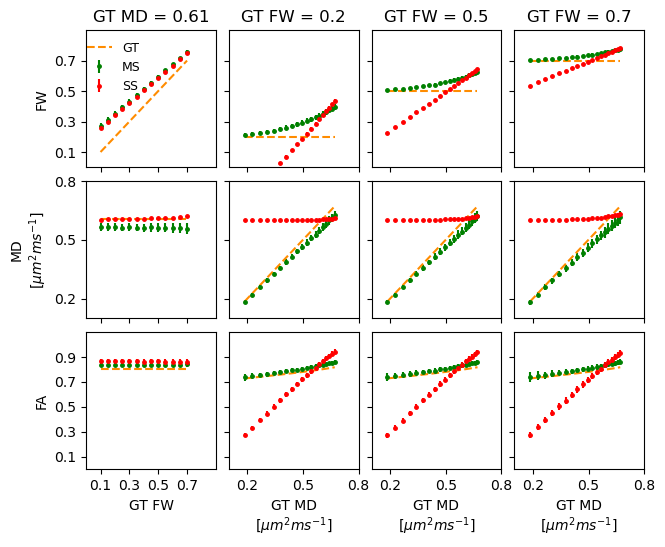

In [18]:
# ------------------------------------------------------------------------------
print('Plotting figure...')
# ------------------------------------------------------------------------------
msize = 5  # Marker size
lw = 1.5   # Line width

colors = {0: 'green',2: 'red', 3: 'darkorange'}
labels = {0: 'MS', 2: 'SS', 3: 'GT'}

fig = plt.figure(figsize=(7.2, 5.7))
gs = gridspec.GridSpec(3, 4)
# gs.update(hspace=0.08, wspace=0.05)
gs.update(hspace=0.1, wspace=0.1)


ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])

ax5 = plt.subplot(gs[1, 0])
ax6 = plt.subplot(gs[1, 1])
ax7 = plt.subplot(gs[1, 2])
ax8 = plt.subplot(gs[1, 3])

ax9 = plt.subplot(gs[2, 0])
ax10 = plt.subplot(gs[2, 1])
ax11 = plt.subplot(gs[2, 2])
ax12 = plt.subplot(gs[2, 3])

# y labels
ax1.set_ylabel('FW')
ax5.set_ylabel('MD\n' + r'$[\mu m^2 ms^{-1}]$')
ax9.set_ylabel('FA')

# x labels
ax9.set_xlabel('GT FW')
ax10.set_xlabel('GT MD\n' + r'$[\mu m^2 ms^{-1}]$')
ax11.set_xlabel('GT MD\n' + r'$[\mu m^2 ms^{-1}]$')
ax12.set_xlabel('GT MD\n' + r'$[\mu m^2 ms^{-1}]$')

# axes limits

MD_lims = [0.1, 0.8]
#MD_lims = [0.1, 1]
#MD_lims = [0.1, 1.2]
FW_lims = [0, 0.9]
FA_lims = [0, 1.1]

# xlims
ax1.set_xlim(FW_lims)
ax2.set_xlim(MD_lims)
ax3.set_xlim(MD_lims)
ax4.set_xlim(MD_lims)

ax5.set_xlim(FW_lims)
ax6.set_xlim(MD_lims)
ax7.set_xlim(MD_lims)
ax8.set_xlim(MD_lims)

ax9.set_xlim(FW_lims)
ax10.set_xlim(MD_lims)
ax11.set_xlim(MD_lims)
ax12.set_xlim(MD_lims)

# ylims
ax1.set_ylim(FW_lims)
ax2.set_ylim(FW_lims)
ax3.set_ylim(FW_lims)
ax4.set_ylim(FW_lims)

ax5.set_ylim(MD_lims)
ax6.set_ylim(MD_lims)
ax7.set_ylim(MD_lims)
ax8.set_ylim(MD_lims)

ax9.set_ylim(FA_lims)
ax10.set_ylim(FA_lims)
ax11.set_ylim(FA_lims)
ax12.set_ylim(FA_lims)

# ticks an tick labels
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])
ax5.set_xticklabels([])
ax6.set_xticklabels([])
ax7.set_xticklabels([])
ax8.set_xticklabels([])

ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax6.set_yticklabels([])
ax7.set_yticklabels([])
ax8.set_yticklabels([])
ax10.set_yticklabels([])
ax11.set_yticklabels([])
ax12.set_yticklabels([])

MD_ticks = np.array([0.2, 0.5, 0.8])
#MD_ticks = np.array([0.2, 0.5, 0.8, 1.1])
FW_ticks = np.array([0.1, 0.3, 0.5, 0.7])
FA_ticks = np.array([0.1, 0.3, 0.5, 0.7, 0.9])

ax1.set_xticks(FW_ticks)
ax5.set_xticks(FW_ticks)
ax9.set_xticks(FW_ticks)

ax2.set_xticks(MD_ticks)
ax3.set_xticks(MD_ticks)
ax4.set_xticks(MD_ticks)
ax6.set_xticks(MD_ticks)
ax7.set_xticks(MD_ticks)
ax8.set_xticks(MD_ticks)
ax10.set_xticks(MD_ticks)
ax11.set_xticks(MD_ticks)
ax12.set_xticks(MD_ticks)

ax1.set_yticks(FW_ticks)
ax2.set_yticks(FW_ticks)
ax3.set_yticks(FW_ticks)
ax4.set_yticks(FW_ticks)

ax5.set_yticks(np.array(MD_ticks))
ax6.set_yticks(np.array(MD_ticks))
ax7.set_yticks(np.array(MD_ticks))
ax8.set_yticks(np.array(MD_ticks))

ax9.set_yticks(FA_ticks)
ax10.set_yticks(FA_ticks)
ax11.set_yticks(FA_ticks)
ax12.set_yticks(FA_ticks)

# Data for fixed MD = 0.6
md_i = np.argmin(np.abs(MDs-0.6))

# FW
median_fw = np.median(F_fwdti[md_i, ...], axis=-1)
p25_fw, p75_fw = np.percentile(F_fwdti[md_i, ...], [25, 75], axis=-1)
low_fw = median_fw - p25_fw
high_fw = p75_fw - median_fw

median_fw_hybrid = np.median(1 - f0_hybrid[md_i, ...], axis=-1)
p25_fw_hybrid, p75_fw_hybrid = np.percentile(1 - f0_hybrid[md_i, ...], [25, 75], axis=-1)
low_fw_hybrid = median_fw_hybrid - p25_fw_hybrid
high_fw_hybrid = p75_fw_hybrid - median_fw_hybrid

# FA
gt_fa = FAs[md_i] * np.ones(nFrac)
median_fa = np.median(FA_fwdti[md_i, ...], axis=-1)
p25_fa, p75_fa = np.percentile(FA_fwdti[md_i, ...], [25, 75], axis=-1)
low_fa = median_fa - p25_fa
high_fa = p75_fa - median_fa

median_fa_hybrid = np.median(fa_hybrid[md_i, ...], axis=-1)
p25_fa_hybrid, p75_fa_hybrid = np.percentile(fa_hybrid[md_i, ...], [25, 75], axis=-1)
low_fa_hybrid = median_fa_hybrid - p25_fa_hybrid
high_fa_hybrid = p75_fa_hybrid - median_fa_hybrid

median_fa_ref = np.median(fa_ref[md_i, ...], axis=-1)

# MD
gt_md = MDs[md_i] * np.ones(nFrac)
median_md = np.median(MD_fwdti[md_i, ...], axis=-1)
p25_md, p75_md = np.percentile(MD_fwdti[md_i, ...], [25, 75], axis=-1)
low_md = median_md - p25_md
high_md = p75_md - median_md

median_md_hybrid = np.median(md_hybrid[md_i, ...], axis=-1)
p25_md_hybrid, p75_md_hybrid = np.percentile(md_hybrid[md_i, ...], [25, 75], axis=-1)
low_md_hybrid = median_md_hybrid - p25_md_hybrid
high_md_hybrid = p75_md_hybrid - median_md_hybrid

ax1.errorbar(FWs, median_fw, fmt='.', yerr=[low_fw, high_fw],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax1.errorbar(FWs, median_fw_hybrid, fmt='.',
              yerr=[low_fw_hybrid, high_fw_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax1.plot(FWs, FWs, color=colors[3], label=labels[3], linewidth=lw, ls='--')
ax1.set_title('GT MD = ' + str(round(float(MDs[md_i]), 2)))
ax1.legend(loc='center left', bbox_to_anchor=(-0.08, 0.73), prop={'size': 9},
           frameon=False)

#-------------------------------------------------------------------------------
ax5.errorbar(FWs, median_md, fmt='.', yerr=[low_md, high_md],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax5.errorbar(FWs, median_md_hybrid, fmt='.',
              yerr=[low_md_hybrid, high_md_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax5.plot(FWs, gt_md, color=colors[3], label=labels[3], linewidth=lw, ls='--')

#-------------------------------------------------------------------------------
ax9.errorbar(FWs, median_fa, fmt='.', yerr=[low_fa, high_fa],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax9.errorbar(FWs, median_fa_hybrid, fmt='.',
              yerr=[low_fa_hybrid, high_fa_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax9.plot(FWs, gt_fa, color=colors[3], label=labels[3], linewidth=lw, ls='--')

# Data for fixed FW = 0.2
f_i = 2

# FW
gt_fw = FWs[f_i] * np.ones(nMDs)
median_fw = np.median(F_fwdti[:, f_i, ...], axis=-1)
p25_fw, p75_fw = np.percentile(F_fwdti[:, f_i, ...], [25, 75], axis=-1)
low_fw = median_fw - p25_fw
high_fw = p75_fw - median_fw

median_fw_hybrid = np.median(1 - f0_hybrid[:, f_i, ...], axis=-1)
p25_fw_hybrid, p75_fw_hybrid = np.percentile(1 - f0_hybrid[:, f_i, ...], [25, 75], axis=-1)
low_fw_hybrid = median_fw_hybrid - p25_fw_hybrid
high_fw_hybrid = p75_fw_hybrid - median_fw_hybrid

# FA
gt_fa = FAs
median_fa = np.median(FA_fwdti[:, f_i, ...], axis=-1)
p25_fa, p75_fa = np.percentile(FA_fwdti[:, f_i, ...], [25, 75], axis=-1)
low_fa = median_fa - p25_fa
high_fa = p75_fa - median_fa

median_fa_hybrid = np.median(fa_hybrid[:, f_i, ...], axis=-1)
p25_fa_hybrid, p75_fa_hybrid = np.percentile(fa_hybrid[:, f_i, ...], [25, 75], axis=-1)
low_fa_hybrid = median_fa_hybrid - p25_fa_hybrid
high_fa_hybrid = p75_fa_hybrid - median_fa_hybrid

median_fa_ref = np.median(fa_ref[:, f_i, ...], axis=-1)

# MD
median_md = np.median(MD_fwdti[:, f_i, ...], axis=-1)
p25_md, p75_md = np.percentile(MD_fwdti[:, f_i, ...], [25, 75], axis=-1)
low_md = median_md - p25_md
high_md = p75_md - median_md

median_md_hybrid = np.median(md_hybrid[:, f_i, ...], axis=-1)
p25_md_hybrid, p75_md_hybrid = np.percentile(md_hybrid[:, f_i, ...], [25, 75], axis=-1)
low_md_hybrid = median_md_hybrid - p25_md_hybrid
high_md_hybrid = p75_md_hybrid - median_md_hybrid

median_md_ref = np.median(md_ref[:, f_i, ...], axis=-1)

ax2.errorbar(MDs, median_fw, fmt='.', yerr=[low_fw, high_fw],
             color=colors[0], ecolor=colors[0], linewidth=lw,
             label=labels[0], markersize=msize)

ax2.errorbar(MDs, median_fw_hybrid, fmt='.',
             yerr=[low_fw_hybrid, high_fw_hybrid],
             color=colors[2], ecolor=colors[2], linewidth=lw,
             label=labels[2], markersize=msize)

ax2.plot(MDs, gt_fw, color=colors[3], label=labels[3], linewidth=lw, ls='--')

ax2.set_title('GT FW = ' + str(FWs[f_i]))

#-------------------------------------------------------------------------------
ax6.errorbar(MDs, median_md, fmt='.', yerr=[low_md, high_md],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax6.errorbar(MDs, median_md_hybrid, fmt='.',
              yerr=[low_md_hybrid, high_md_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax6.plot(MDs, MDs, color=colors[3], label=labels[3], linewidth=lw, ls='--')

#-------------------------------------------------------------------------------
ax10.errorbar(MDs, median_fa, fmt='.', yerr=[low_fa, high_fa],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax10.errorbar(MDs, median_fa_hybrid, fmt='.',
              yerr=[low_fa_hybrid, high_fa_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax10.plot(MDs, gt_fa, color=colors[3], label=labels[3], linewidth=lw, ls='--')

# Data for fixed FW = 0.5
f_i = 8

# FW
gt_fw = FWs[f_i] * np.ones(nMDs)
median_fw = np.median(F_fwdti[:, f_i, ...], axis=-1)
p25_fw, p75_fw = np.percentile(F_fwdti[:, f_i, ...], [25, 75], axis=-1)
low_fw = median_fw - p25_fw
high_fw = p75_fw - median_fw

median_fw_hybrid = np.median(1 - f0_hybrid[:, f_i, ...], axis=-1)
p25_fw_hybrid, p75_fw_hybrid = np.percentile(1 - f0_hybrid[:, f_i, ...], [25, 75], axis=-1)
low_fw_hybrid = median_fw_hybrid - p25_fw_hybrid
high_fw_hybrid = p75_fw_hybrid - median_fw_hybrid


# FA
gt_fa = FAs
median_fa = np.median(FA_fwdti[:, f_i, ...], axis=-1)
p25_fa, p75_fa = np.percentile(FA_fwdti[:, f_i, ...], [25, 75], axis=-1)
low_fa = median_fa - p25_fa
high_fa = p75_fa - median_fa

median_fa_hybrid = np.median(fa_hybrid[:, f_i, ...], axis=-1)
p25_fa_hybrid, p75_fa_hybrid = np.percentile(fa_hybrid[:, f_i, ...], [25, 75], axis=-1)
low_fa_hybrid = median_fa_hybrid - p25_fa_hybrid
high_fa_hybrid = p75_fa_hybrid - median_fa_hybrid

median_fa_ref = np.median(fa_ref[:, f_i, ...], axis=-1)

# MD
median_md = np.median(MD_fwdti[:, f_i, ...], axis=-1)
p25_md, p75_md = np.percentile(MD_fwdti[:, f_i, ...], [25, 75], axis=-1)
low_md = median_md - p25_md
high_md = p75_md - median_md

median_md_hybrid = np.median(md_hybrid[:, f_i, ...], axis=-1)
p25_md_hybrid, p75_md_hybrid = np.percentile(md_hybrid[:, f_i, ...], [25, 75], axis=-1)
low_md_hybrid = median_md_hybrid - p25_md_hybrid
high_md_hybrid = p75_md_hybrid - median_md_hybrid

median_md_ref = np.median(md_ref[:, f_i, ...], axis=-1)

ax3.errorbar(MDs, median_fw, fmt='.', yerr=[low_fw, high_fw],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax3.errorbar(MDs, median_fw_hybrid, fmt='.',
              yerr=[low_fw_hybrid, high_fw_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax3.plot(MDs, gt_fw, color=colors[3], label=labels[3], linewidth=lw, ls='--')
ax3.set_title('GT FW = ' + str(FWs[f_i]))

#-------------------------------------------------------------------------------
ax7.errorbar(MDs, median_md, fmt='.', yerr=[low_md, high_md],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax7.errorbar(MDs, median_md_hybrid, fmt='.',
              yerr=[low_md_hybrid, high_md_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax7.plot(MDs, MDs, color=colors[3], label=labels[3], linewidth=lw, ls='--')

#-------------------------------------------------------------------------------
ax11.errorbar(MDs, median_fa, fmt='.', yerr=[low_fa, high_fa],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax11.errorbar(MDs, median_fa_hybrid, fmt='.',
              yerr=[low_fa_hybrid, high_fa_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax11.plot(MDs, gt_fa, color=colors[3], label=labels[3], linewidth=lw, ls='--')

# Data for fixed FW = 0.7
f_i = 12

# FW
gt_fw = FWs[f_i] * np.ones(nMDs)
median_fw = np.median(F_fwdti[:, f_i, ...], axis=-1)
p25_fw, p75_fw = np.percentile(F_fwdti[:, f_i, ...], [25, 75], axis=-1)
low_fw = median_fw - p25_fw
high_fw = p75_fw - median_fw

median_fw_hybrid = np.median(1 - f0_hybrid[:, f_i, ...], axis=-1)
p25_fw_hybrid, p75_fw_hybrid = np.percentile(1 - f0_hybrid[:, f_i, ...], [25, 75], axis=-1)
low_fw_hybrid = median_fw_hybrid - p25_fw_hybrid
high_fw_hybrid = p75_fw_hybrid - median_fw_hybrid

# FA
gt_fa = FAs
median_fa = np.median(FA_fwdti[:, f_i, ...], axis=-1)
p25_fa, p75_fa = np.percentile(FA_fwdti[:, f_i, ...], [25, 75], axis=-1)
low_fa = median_fa - p25_fa
high_fa = p75_fa - median_fa

median_fa_hybrid = np.median(fa_hybrid[:, f_i, ...], axis=-1)
p25_fa_hybrid, p75_fa_hybrid = np.percentile(fa_hybrid[:, f_i, ...], [25, 75], axis=-1)
low_fa_hybrid = median_fa_hybrid - p25_fa_hybrid
high_fa_hybrid = p75_fa_hybrid - median_fa_hybrid

median_fa_ref = np.median(fa_ref[:, f_i, ...], axis=-1)

# MD
median_md = np.median(MD_fwdti[:, f_i, ...], axis=-1)
p25_md, p75_md = np.percentile(MD_fwdti[:, f_i, ...], [25, 75], axis=-1)
low_md = median_md - p25_md
high_md = p75_md - median_md

median_md_hybrid = np.median(md_hybrid[:, f_i, ...], axis=-1)
p25_md_hybrid, p75_md_hybrid = np.percentile(md_hybrid[:, f_i, ...], [25, 75], axis=-1)
low_md_hybrid = median_md_hybrid - p25_md_hybrid
high_md_hybrid = p75_md_hybrid - median_md_hybrid

median_md_ref = np.median(md_ref[:, f_i, ...], axis=-1)

ax4.errorbar(MDs, median_fw, fmt='.', yerr=[low_fw, high_fw],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax4.errorbar(MDs, median_fw_hybrid, fmt='.',
              yerr=[low_fw_hybrid, high_fw_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax4.plot(MDs, gt_fw, color=colors[3], label=labels[3], linewidth=lw, ls='--')
ax4.set_title('GT FW = ' + str(FWs[f_i]))

#-------------------------------------------------------------------------------
ax8.errorbar(MDs, median_md, fmt='.', yerr=[low_md, high_md],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax8.errorbar(MDs, median_md_hybrid, fmt='.',
              yerr=[low_md_hybrid, high_md_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax8.plot(MDs, MDs, color=colors[3], label=labels[3], linewidth=lw, ls='--')

#-------------------------------------------------------------------------------
ax12.errorbar(MDs, median_fa, fmt='.', yerr=[low_fa, high_fa],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax12.errorbar(MDs, median_fa_hybrid, fmt='.',
              yerr=[low_fa_hybrid, high_fa_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax12.plot(MDs, gt_fa, color=colors[3], label=labels[3], linewidth=lw, ls='--')
    
plt.show()

Plotting figure...


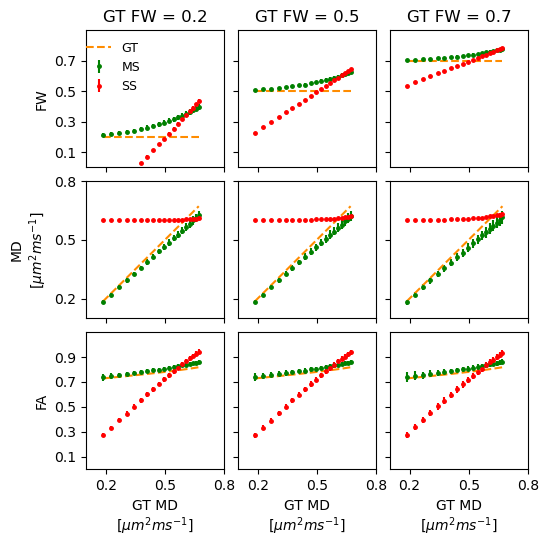

In [19]:
# ------------------------------------------------------------------------------
print('Plotting figure...')
# ------------------------------------------------------------------------------
msize = 5  # Marker size
lw = 1.5   # Line width

colors = {0: 'green',2: 'red', 3: 'darkorange'}
labels = {0: 'MS', 2: 'SS', 3: 'GT'}

fig = plt.figure(figsize=(5.7, 5.7))
gs = gridspec.GridSpec(3, 3)
# gs.update(hspace=0.08, wspace=0.05)
gs.update(hspace=0.1, wspace=0.1)


ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])

ax4 = plt.subplot(gs[1, 0])
ax5 = plt.subplot(gs[1, 1])
ax6 = plt.subplot(gs[1, 2])

ax7 = plt.subplot(gs[2, 0])
ax8 = plt.subplot(gs[2, 1])
ax9 = plt.subplot(gs[2, 2])

# y labels
ax1.set_ylabel('FW')
ax4.set_ylabel('MD\n' + r'$[\mu m^2 ms^{-1}]$')
ax7.set_ylabel('FA')

# x labels
ax7.set_xlabel('GT MD\n' + r'$[\mu m^2 ms^{-1}]$')
ax8.set_xlabel('GT MD\n' + r'$[\mu m^2 ms^{-1}]$')
ax9.set_xlabel('GT MD\n' + r'$[\mu m^2 ms^{-1}]$')

# xlims
ax1.set_xlim(MD_lims)
ax2.set_xlim(MD_lims)
ax3.set_xlim(MD_lims)
ax4.set_xlim(MD_lims)
ax5.set_xlim(MD_lims)
ax6.set_xlim(MD_lims)
ax7.set_xlim(MD_lims)
ax8.set_xlim(MD_lims)
ax9.set_xlim(MD_lims)

# ylims
ax1.set_ylim(FW_lims)
ax2.set_ylim(FW_lims)
ax3.set_ylim(FW_lims)

ax4.set_ylim(MD_lims)
ax5.set_ylim(MD_lims)
ax6.set_ylim(MD_lims)

ax7.set_ylim(FA_lims)
ax8.set_ylim(FA_lims)
ax9.set_ylim(FA_lims)

# ticks an tick labels
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])
ax5.set_xticklabels([])
ax6.set_xticklabels([])

ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
ax8.set_yticklabels([])
ax9.set_yticklabels([])

MD_ticks = np.array(MD_ticks)
FW_ticks = np.array(FW_ticks)
FA_ticks = np.array(FA_ticks)

ax1.set_xticks(MD_ticks)
ax2.set_xticks(MD_ticks)
ax3.set_xticks(MD_ticks)
ax4.set_xticks(MD_ticks)
ax5.set_xticks(MD_ticks)
ax6.set_xticks(MD_ticks)
ax7.set_xticks(MD_ticks)
ax8.set_xticks(MD_ticks)
ax9.set_xticks(MD_ticks)

ax1.set_yticks(FW_ticks)
ax2.set_yticks(FW_ticks)
ax3.set_yticks(FW_ticks)

ax4.set_yticks(np.array(MD_ticks))
ax5.set_yticks(np.array(MD_ticks))
ax6.set_yticks(np.array(MD_ticks))

ax7.set_yticks(FA_ticks)
ax8.set_yticks(FA_ticks)
ax9.set_yticks(FA_ticks)

# Data for fixed MD = 0.6
md_i = np.argmin(np.abs(MDs-0.6))

# FW
median_fw = np.median(F_fwdti[md_i, ...], axis=-1)
p25_fw, p75_fw = np.percentile(F_fwdti[md_i, ...], [25, 75], axis=-1)
low_fw = median_fw - p25_fw
high_fw = p75_fw - median_fw

median_fw_hybrid = np.median(1 - f0_hybrid[md_i, ...], axis=-1)
p25_fw_hybrid, p75_fw_hybrid = np.percentile(1 - f0_hybrid[md_i, ...], [25, 75], axis=-1)
low_fw_hybrid = median_fw_hybrid - p25_fw_hybrid
high_fw_hybrid = p75_fw_hybrid - median_fw_hybrid

# FA
gt_fa = FAs[md_i] * np.ones(nFrac)
median_fa = np.median(FA_fwdti[md_i, ...], axis=-1)
p25_fa, p75_fa = np.percentile(FA_fwdti[md_i, ...], [25, 75], axis=-1)
low_fa = median_fa - p25_fa
high_fa = p75_fa - median_fa

median_fa_hybrid = np.median(fa_hybrid[md_i, ...], axis=-1)
p25_fa_hybrid, p75_fa_hybrid = np.percentile(fa_hybrid[md_i, ...], [25, 75], axis=-1)
low_fa_hybrid = median_fa_hybrid - p25_fa_hybrid
high_fa_hybrid = p75_fa_hybrid - median_fa_hybrid

median_fa_ref = np.median(fa_ref[md_i, ...], axis=-1)

# Data for fixed FW = 0.2
f_i = 2

# FW
gt_fw = FWs[f_i] * np.ones(nMDs)
median_fw = np.median(F_fwdti[:, f_i, ...], axis=-1)
p25_fw, p75_fw = np.percentile(F_fwdti[:, f_i, ...], [25, 75], axis=-1)
low_fw = median_fw - p25_fw
high_fw = p75_fw - median_fw

median_fw_hybrid = np.median(1 - f0_hybrid[:, f_i, ...], axis=-1)
p25_fw_hybrid, p75_fw_hybrid = np.percentile(1 - f0_hybrid[:, f_i, ...], [25, 75], axis=-1)
low_fw_hybrid = median_fw_hybrid - p25_fw_hybrid
high_fw_hybrid = p75_fw_hybrid - median_fw_hybrid

# FA
gt_fa = FAs
median_fa = np.median(FA_fwdti[:, f_i, ...], axis=-1)
p25_fa, p75_fa = np.percentile(FA_fwdti[:, f_i, ...], [25, 75], axis=-1)
low_fa = median_fa - p25_fa
high_fa = p75_fa - median_fa

median_fa_hybrid = np.median(fa_hybrid[:, f_i, ...], axis=-1)
p25_fa_hybrid, p75_fa_hybrid = np.percentile(fa_hybrid[:, f_i, ...], [25, 75], axis=-1)
low_fa_hybrid = median_fa_hybrid - p25_fa_hybrid
high_fa_hybrid = p75_fa_hybrid - median_fa_hybrid

median_fa_ref = np.median(fa_ref[:, f_i, ...], axis=-1)

# MD
median_md = np.median(MD_fwdti[:, f_i, ...], axis=-1)
p25_md, p75_md = np.percentile(MD_fwdti[:, f_i, ...], [25, 75], axis=-1)
low_md = median_md - p25_md
high_md = p75_md - median_md

median_md_hybrid = np.median(md_hybrid[:, f_i, ...], axis=-1)
p25_md_hybrid, p75_md_hybrid = np.percentile(md_hybrid[:, f_i, ...], [25, 75], axis=-1)
low_md_hybrid = median_md_hybrid - p25_md_hybrid
high_md_hybrid = p75_md_hybrid - median_md_hybrid

median_md_ref = np.median(md_ref[:, f_i, ...], axis=-1)

ax1.errorbar(MDs, median_fw, fmt='.', yerr=[low_fw, high_fw],
             color=colors[0], ecolor=colors[0], linewidth=lw,
             label=labels[0], markersize=msize)

ax1.errorbar(MDs, median_fw_hybrid, fmt='.',
             yerr=[low_fw_hybrid, high_fw_hybrid],
             color=colors[2], ecolor=colors[2], linewidth=lw,
             label=labels[2], markersize=msize)

ax1.plot(MDs, gt_fw, color=colors[3], label=labels[3], linewidth=lw, ls='--')

ax1.set_title('GT FW = ' + str(FWs[f_i]))
ax1.legend(loc='center left', bbox_to_anchor=(-0.08, 0.73), prop={'size': 9},
           frameon=False)

#-------------------------------------------------------------------------------
ax4.errorbar(MDs, median_md, fmt='.', yerr=[low_md, high_md],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax4.errorbar(MDs, median_md_hybrid, fmt='.',
              yerr=[low_md_hybrid, high_md_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax4.plot(MDs, MDs, color=colors[3], label=labels[3], linewidth=lw, ls='--')

#-------------------------------------------------------------------------------
ax7.errorbar(MDs, median_fa, fmt='.', yerr=[low_fa, high_fa],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax7.errorbar(MDs, median_fa_hybrid, fmt='.',
              yerr=[low_fa_hybrid, high_fa_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax7.plot(MDs, gt_fa, color=colors[3], label=labels[3], linewidth=lw, ls='--')

# Data for fixed FW = 0.5
f_i = 8

# FW
gt_fw = FWs[f_i] * np.ones(nMDs)
median_fw = np.median(F_fwdti[:, f_i, ...], axis=-1)
p25_fw, p75_fw = np.percentile(F_fwdti[:, f_i, ...], [25, 75], axis=-1)
low_fw = median_fw - p25_fw
high_fw = p75_fw - median_fw

median_fw_hybrid = np.median(1 - f0_hybrid[:, f_i, ...], axis=-1)
p25_fw_hybrid, p75_fw_hybrid = np.percentile(1 - f0_hybrid[:, f_i, ...], [25, 75], axis=-1)
low_fw_hybrid = median_fw_hybrid - p25_fw_hybrid
high_fw_hybrid = p75_fw_hybrid - median_fw_hybrid


# FA
gt_fa = FAs
median_fa = np.median(FA_fwdti[:, f_i, ...], axis=-1)
p25_fa, p75_fa = np.percentile(FA_fwdti[:, f_i, ...], [25, 75], axis=-1)
low_fa = median_fa - p25_fa
high_fa = p75_fa - median_fa

median_fa_hybrid = np.median(fa_hybrid[:, f_i, ...], axis=-1)
p25_fa_hybrid, p75_fa_hybrid = np.percentile(fa_hybrid[:, f_i, ...], [25, 75], axis=-1)
low_fa_hybrid = median_fa_hybrid - p25_fa_hybrid
high_fa_hybrid = p75_fa_hybrid - median_fa_hybrid

median_fa_ref = np.median(fa_ref[:, f_i, ...], axis=-1)

# MD
median_md = np.median(MD_fwdti[:, f_i, ...], axis=-1)
p25_md, p75_md = np.percentile(MD_fwdti[:, f_i, ...], [25, 75], axis=-1)
low_md = median_md - p25_md
high_md = p75_md - median_md

median_md_hybrid = np.median(md_hybrid[:, f_i, ...], axis=-1)
p25_md_hybrid, p75_md_hybrid = np.percentile(md_hybrid[:, f_i, ...], [25, 75], axis=-1)
low_md_hybrid = median_md_hybrid - p25_md_hybrid
high_md_hybrid = p75_md_hybrid - median_md_hybrid

median_md_ref = np.median(md_ref[:, f_i, ...], axis=-1)

ax2.errorbar(MDs, median_fw, fmt='.', yerr=[low_fw, high_fw],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax2.errorbar(MDs, median_fw_hybrid, fmt='.',
              yerr=[low_fw_hybrid, high_fw_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax2.plot(MDs, gt_fw, color=colors[3], label=labels[3], linewidth=lw, ls='--')
ax2.set_title('GT FW = ' + str(FWs[f_i]))

#-------------------------------------------------------------------------------
ax5.errorbar(MDs, median_md, fmt='.', yerr=[low_md, high_md],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax5.errorbar(MDs, median_md_hybrid, fmt='.',
              yerr=[low_md_hybrid, high_md_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax5.plot(MDs, MDs, color=colors[3], label=labels[3], linewidth=lw, ls='--')

#-------------------------------------------------------------------------------
ax8.errorbar(MDs, median_fa, fmt='.', yerr=[low_fa, high_fa],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax8.errorbar(MDs, median_fa_hybrid, fmt='.',
              yerr=[low_fa_hybrid, high_fa_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax8.plot(MDs, gt_fa, color=colors[3], label=labels[3], linewidth=lw, ls='--')

# Data for fixed FW = 0.7
f_i = 12

# FW
gt_fw = FWs[f_i] * np.ones(nMDs)
median_fw = np.median(F_fwdti[:, f_i, ...], axis=-1)
p25_fw, p75_fw = np.percentile(F_fwdti[:, f_i, ...], [25, 75], axis=-1)
low_fw = median_fw - p25_fw
high_fw = p75_fw - median_fw

median_fw_hybrid = np.median(1 - f0_hybrid[:, f_i, ...], axis=-1)
p25_fw_hybrid, p75_fw_hybrid = np.percentile(1 - f0_hybrid[:, f_i, ...], [25, 75], axis=-1)
low_fw_hybrid = median_fw_hybrid - p25_fw_hybrid
high_fw_hybrid = p75_fw_hybrid - median_fw_hybrid

# FA
gt_fa = FAs
median_fa = np.median(FA_fwdti[:, f_i, ...], axis=-1)
p25_fa, p75_fa = np.percentile(FA_fwdti[:, f_i, ...], [25, 75], axis=-1)
low_fa = median_fa - p25_fa
high_fa = p75_fa - median_fa

median_fa_hybrid = np.median(fa_hybrid[:, f_i, ...], axis=-1)
p25_fa_hybrid, p75_fa_hybrid = np.percentile(fa_hybrid[:, f_i, ...], [25, 75], axis=-1)
low_fa_hybrid = median_fa_hybrid - p25_fa_hybrid
high_fa_hybrid = p75_fa_hybrid - median_fa_hybrid

median_fa_ref = np.median(fa_ref[:, f_i, ...], axis=-1)

# MD
median_md = np.median(MD_fwdti[:, f_i, ...], axis=-1)
p25_md, p75_md = np.percentile(MD_fwdti[:, f_i, ...], [25, 75], axis=-1)
low_md = median_md - p25_md
high_md = p75_md - median_md

median_md_hybrid = np.median(md_hybrid[:, f_i, ...], axis=-1)
p25_md_hybrid, p75_md_hybrid = np.percentile(md_hybrid[:, f_i, ...], [25, 75], axis=-1)
low_md_hybrid = median_md_hybrid - p25_md_hybrid
high_md_hybrid = p75_md_hybrid - median_md_hybrid

median_md_ref = np.median(md_ref[:, f_i, ...], axis=-1)

ax3.errorbar(MDs, median_fw, fmt='.', yerr=[low_fw, high_fw],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax3.errorbar(MDs, median_fw_hybrid, fmt='.',
              yerr=[low_fw_hybrid, high_fw_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax3.plot(MDs, gt_fw, color=colors[3], label=labels[3], linewidth=lw, ls='--')
ax3.set_title('GT FW = ' + str(FWs[f_i]))

#-------------------------------------------------------------------------------
ax6.errorbar(MDs, median_md, fmt='.', yerr=[low_md, high_md],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax6.errorbar(MDs, median_md_hybrid, fmt='.',
              yerr=[low_md_hybrid, high_md_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax6.plot(MDs, MDs, color=colors[3], label=labels[3], linewidth=lw, ls='--')

#-------------------------------------------------------------------------------
ax9.errorbar(MDs, median_fa, fmt='.', yerr=[low_fa, high_fa],
              color=colors[0], ecolor=colors[0], linewidth=lw,
              label=labels[0], markersize=msize)

ax9.errorbar(MDs, median_fa_hybrid, fmt='.',
              yerr=[low_fa_hybrid, high_fa_hybrid],
              color=colors[2], ecolor=colors[2], linewidth=lw,
              label=labels[2], markersize=msize)

ax9.plot(MDs, gt_fa, color=colors[3], label=labels[3], linewidth=lw, ls='--')
    
plt.show()